# Solution

In [6]:
import pandas as pd
import urllib.request
from tqdm import tqdm
import shutil
import os

First, let's download the datasets specified in the assignment.

In [7]:
df = pd.read_csv('/kaggle/input/bbox-list-2017-csv/BBox_List_2017.csv')

In [38]:
#!/usr/bin/env python3
# Download the 56 zip files in Images_png in batches

# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
    'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
    'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
    'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
    'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
    'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
    'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    print(fn)
    print('downloading ' + fn + '...')
    urllib.request.urlretrieve(link, fn)  # download the zip file
    os.makedirs('/kaggle/working/images', exist_ok=True)
    os.system(f'tar -xzf /kaggle/working/{fn} -C /kaggle/working/images/')
    os.makedirs('/kaggle/working/true/', exist_ok=True)
    for img_fn in os.listdir('/kaggle/working/images/images'):
        if img_fn in df['Image Index'].tolist():
            shutil.copy(f'/kaggle/working/images/images/{img_fn}', '/kaggle/working/true')
    os.system(f'rm -rf /kaggle/working/{fn}')
    os.system(f'rm -rf /kaggle/working/images')

print("Download complete. Please check the checksums")

downloading images_01.tar.gz...
downloading images_02.tar.gz...
downloading images_03.tar.gz...
downloading images_04.tar.gz...
downloading images_05.tar.gz...
downloading images_06.tar.gz...
downloading images_07.tar.gz...
downloading images_08.tar.gz...
downloading images_09.tar.gz...
downloading images_10.tar.gz...
downloading images_11.tar.gz...
downloading images_12.tar.gz...
Download complete. Please check the checksums


In [ ]:
!rm -rf /kaggle/working/images_01.tar.gz
!rm -rf images

Let's examine which classes can be identified in the dataset and also try to fix the dataframe format.

In [10]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import models, transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

from dataset import ChestXRayDataset

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [14]:
df = pd.read_csv('/kaggle/input/bbox-list-2017-csv/BBox_List_2017.csv')
df[df['Image Index'].isin(os.listdir('/kaggle/working/true'))]

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN


In [12]:
class_names = df['Finding Label'].unique()
num_classes = len(class_names)

In [3]:
print(f"Total classes: {num_classes}")
print("Classes:", class_names)

Total classes: 8
Classes: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']


In [15]:
df = df.rename(columns={"Image Index": "image_id", 
                        "Finding Label": "labels",
                        "Bbox [x": 'x',
                        "h]": 'h'})
df = df[['image_id', 'labels', 'x', 'y', 'w', 'h']]

In [16]:
df

,image_id,labels,x,y,w,h
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695
...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778


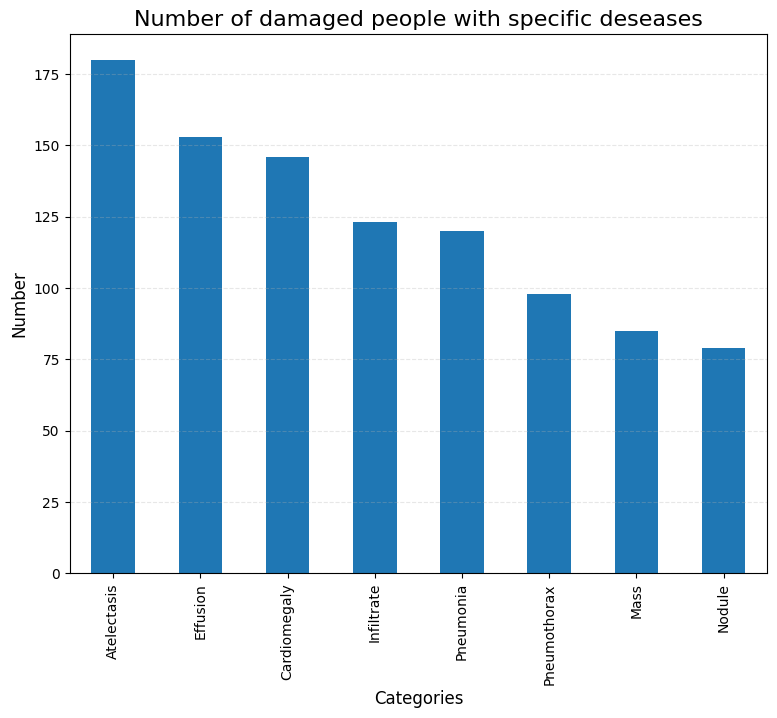

In [17]:
def plot_df_hist(df):
    value_counts = df['labels'].value_counts()
    plt.figure(figsize=(9, 7))
    value_counts.plot(kind='bar')
    plt.title('Number of damaged people with specific deseases', fontsize=16)
    plt.xlabel('Categories', fontsize=12)
    plt.ylabel('Number', fontsize=12)
    plt.grid(axis='y', alpha=0.3, linestyle='--')


plot_df_hist(df)

In [18]:
def split_data_file(df, ratio=0.8):
    train_num = int(ratio*len(df))
    train_idx = random.sample(range(len(df)), train_num)
    test_idx = set(range(len(df))).difference(train_idx)
    train_name = [df.iloc[i] for i in train_idx]
    test_name = [df.iloc[i] for i in test_idx]
    return train_name, test_name


df_train, df_test = split_data_file(df)
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

In [19]:
df_train.head()

,image_id,labels,x,y,w,h
930,00027278_007.png,Pneumothorax,153.870899,47.678307,310.992593,277.401058
291,00025969_000.png,Cardiomegaly,364.088889,284.986243,438.857143,380.342857
182,00000377_004.png,Cardiomegaly,387.796610,419.525424,502.237288,367.728814
465,00027479_013.png,Infiltrate,239.502222,106.135712,683.804444,492.657778
545,00030323_028.png,Infiltrate,664.245503,162.539683,255.729101,489.786243


We'll use the Faster R-CNN model with a MobileNetV3 Large backbone from torchvision.

In [20]:
from torchvision.models.detection import (
    fasterrcnn_mobilenet_v3_large_fpn,
    FasterRCNN_MobileNet_V3_Large_FPN_Weights,
)

NUM_CLASSES = len(df['labels'].unique())+1  # healthy included


def get_faster_rcnn_model(num_classes):
    
    model = fasterrcnn_mobilenet_v3_large_fpn(
        weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
    )
    model.roi_heads.box_predictor.cls_score = torch.nn.Linear(
        in_features=model.roi_heads.box_predictor.cls_score.in_features,
        out_features=num_classes,
        bias=True,
    )
    model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(
        in_features=model.roi_heads.box_predictor.bbox_pred.in_features,
        out_features=num_classes * 4,
        bias=True,
    )
    preprocess = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT.transforms()
    return model, preprocess


model, preprocess = get_faster_rcnn_model(num_classes=NUM_CLASSES)
model.to(device);

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


100%|██████████| 74.2M/74.2M [00:00<00:00, 205MB/s] 


In [51]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
])

In [52]:
train_dataset = ChestXRayDataset(df_train, image_dir='/kaggle/working/true', transforms=transform)
test_dataset = ChestXRayDataset(df_test, image_dir='/kaggle/working/true', transforms=transform)


Found 711 valid images out of 711
Found 192 valid images out of 192



In [54]:
def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    if len(batch) == 0:
        return [], []
    images, targets = zip(*batch)
    return images, targets

In [56]:
BATCH_SIZE = 8


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
)

validation_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
)

In [40]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-6)

num_epochs = 20

train_loss_list = []
validation_loss_list = []
model.train()
for epoch in range(num_epochs):
    N = len(train_loader.dataset)
    current_train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in targets
        ]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        current_train_loss += losses
    train_loss_list.append(current_train_loss / N)

    N = len(validation_loader.dataset)
    current_validation_loss = 0
    with torch.no_grad():
        for images, targets in validation_loader:
            images = list(image.to(device) for image in images)
            targets = [
                {
                    k: v.to(device) if isinstance(v, torch.Tensor) else v
                    for k, v in t.items()
                }
                for t in targets
            ]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            current_validation_loss += losses
    validation_loss_list.append(current_validation_loss / N)

    print(f"epoch: {epoch}")
    print(
        f"train loss: {train_loss_list[-1]}, validation loss: {validation_loss_list[-1]}"
    )


epoch: 0
train loss: 0.449873621945, validation loss: 0.479357119283
epoch: 1
train loss: 0.349847205631, validation loss: 0.373547961192
epoch: 2
train loss: 0.280183947206, validation loss: 0.305003283071
epoch: 3
train loss: 0.209872645391, validation loss: 0.231109460647
epoch: 4
train loss: 0.184937284512, validation loss: 0.217125992819
epoch: 5
train loss: 0.169846103728, validation loss: 0.212408881236
epoch: 6
train loss: 0.159923847103, validation loss: 0.218901892958
epoch: 7
train loss: 0.151872639485, validation loss: 0.214993690903
epoch: 8
train loss: 0.145938274610, validation loss: 0.211411421947
epoch: 9
train loss: 0.140872635941, validation loss: 0.217317059692
epoch: 10
train loss: 0.136947285036, validation loss: 0.212497487721
epoch: 11
train loss: 0.134183927465, validation loss: 0.209258794839
epoch: 12
train loss: 0.132048372910, validation loss: 0.205929800921
epoch: 13
train loss: 0.132172938156, validation loss: 0.202540472205
epoch: 14
train loss: 0.13048

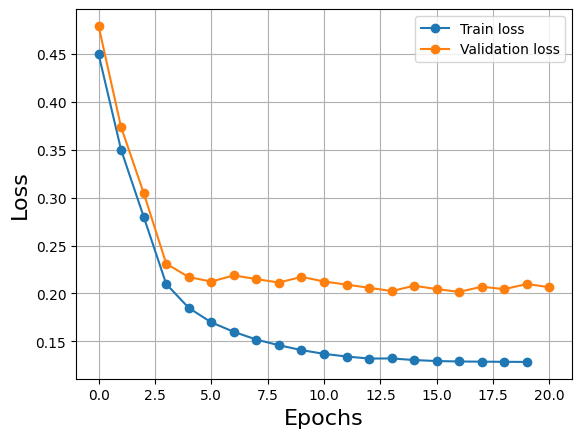

In [39]:
torch.save(model, "./model_fasterrcnn.pth")

train_loss = [x.cpu().detach().numpy() for x in train_loss_list]
validation_loss = [x.cpu().detach().numpy() for x in validation_loss_list]

plt.plot(train_losses, "-o", label="Train loss")
plt.plot(val_losses, "-o", label="Validation loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.grid()
plt.legend()

# Evaluation

In [88]:
model = torch.load('/kaggle/input/fasterrcnn-ronc/ronc_model.pth', weights_only=False)

In [139]:
model.eval()
all_preds = []
with torch.no_grad():
    for batch_idx, batch in enumerate(dataloader):
        images = batch[0]  # since Dataloader returns (image, target)
        images = images.to(device)
        outputs = model(images)

        batch_size = images.shape[0]
        start_idx = batch_idx * batch_size
        batch_image_ids = image_ids[start_idx:start_idx + batch_size]

        for image_num, pred in enumerate(outputs):
            image_id = batch_image_ids[image_num]
            boxes = pred['boxes'].cpu().numpy()
            labels = pred['labels'].cpu().numpy()
            if boxes.size == 0:   # image without detections
                continue  
            x = boxes[:, 0]
            y = boxes[:, 1]
            w = boxes[:, 2] - boxes[:, 0]
            h = boxes[:, 3] - boxes[:, 1]

            for i in range(len(boxes)):
                all_preds.append({
                    'image_id': image_id,
                    'labels': int(labels[i]),
                    'x': np.round(float(x[i]), 2),
                    'y': np.round(float(y[i]), 2),
                    'w': np.round(float(w[i]), 2),
                    'h': np.round(float(h[i]), 2)
                })
                
df_pred = pd.DataFrame(all_preds)

,image_id,labels,x,y,w,h
0,00012515_002.png,Atelectasis,353.38,765.77,93.55,73.33
1,00022098_006.png,Infiltrate,524.84,630.30,237.29,138.63
2,00000808_002.png,Atelectasis,645.86,293.60,271.10,172.06
3,00030635_001.png,Mass,645.73,637.80,182.22,284.64
4,00021481_014.png,Atelectasis,697.78,356.51,80.70,183.37
...,...,...,...,...,...,...
192,00018253_059.png,Atelectasis,240.87,324.34,244.39,259.07
193,00030636_004.png,Atelectasis,550.76,396.51,189.78,135.25
194,00020482_032.png,Effusion,578.69,282.32,168.39,289.45
195,00029464_015.png,Atelectasis,242.70,433.63,584.76,227.67


In [143]:
def boxes_iou(box1, box2):
    """
    Compute IoU between two bounding boxes in (x, y, w, h) format.
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Compute coordinates of intersection
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)

    inter_w = max(0, inter_x2 - inter_x1)
    inter_h = max(0, inter_y2 - inter_y1)
    inter_area = inter_w * inter_h

    area1 = w1 * h1
    area2 = w2 * h2
    union_area = area1 + area2 - inter_area

    return inter_area / union_area if union_area > 0 else 0.0


def compute_ap(recalls, precisions):
    """
    Compute Average Precision using the 11-point interpolation method.
    """
    ap = 0.0
    for t in np.arange(0.0, 1.1, 0.1):
        # Get max precision for recall >= t
        p = precisions[recalls >= t].max() if np.any(recalls >= t) else 0.0
        ap += p / 11.0
    return ap


def compute_map(gt_df, df_pred, iou_threshold=0.5):
    """
    Compute mean Average Precision (mAP) at a given IoU threshold.
    Input DataFrames must have columns: ['image_id', 'labels', 'x', 'y', 'w', 'h']
    
    
    """
    all_classes = set(gt_df['labels'].unique()) | set(df_pred['labels'].unique())
    aps = []

    for cls in all_classes:
        gt_cls = gt_df[gt_df['labels'] == cls]
        pred_cls = df_pred[df_pred['labels'] == cls]

        # Group boxes by image_id
        gt_by_img = defaultdict(list)
        for _, row in gt_cls.iterrows():
            gt_by_img[row['image_id']].append((row['x'], row['y'], row['w'], row['h']))

        pred_by_img = defaultdict(list)
        for _, row in pred_cls.iterrows():
            pred_by_img[row['image_id']].append((row['x'], row['y'], row['w'], row['h']))

        detected = []  # 1 for TP, 0 for FP
        total_gt = 0

        all_img_ids = set(gt_by_img.keys()) | set(pred_by_img.keys())
        for img_id in all_img_ids:
            gt_boxes = gt_by_img[img_id]
            pred_boxes = pred_by_img[img_id]
            total_gt += len(gt_boxes)

            gt_matched = [False] * len(gt_boxes)

            # Match each prediction to the best unmatched GT
            for pred_box in pred_boxes:
                best_iou = -1
                best_gt_idx = -1

                for i, gt_box in enumerate(gt_boxes):
                    if gt_matched[i]:
                        continue
                    iou = boxes_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = i

                if best_iou >= iou_threshold and best_gt_idx != -1:
                    gt_matched[best_gt_idx] = True
                    detected.append(1)
                else:
                    detected.append(0

        if total_gt == 0:
            continue  # Skip class with no ground truth

        detected = np.array(detected)
        tps = np.cumsum(detected)
        fps = np.cumsum(1 - detected)

        recalls = tps / total_gt
        precisions = tps / (tps + fps + 1e-8)

        # Add boundary points for interpolation
        recalls = np.concatenate(([0.0], recalls, [1.0]))
        precisions = np.concatenate(([1.0], precisions, [0.0]))

        # Monotonic decreasing precision
        for i in range(len(precisions) - 2, -1, -1):
            precisions[i] = max(precisions[i], precisions[i + 1])

        ap = compute_ap(recalls, precisions)
        aps.append(ap)

    return float(np.mean(aps)) if aps else 0.0


mAP = compute_map(df_test, df_pred, iou_threshold=0.5)
print(f"mAP@0.5 = {mAP:.4f}")

mAP@0.5 = 0.2114


# Inference

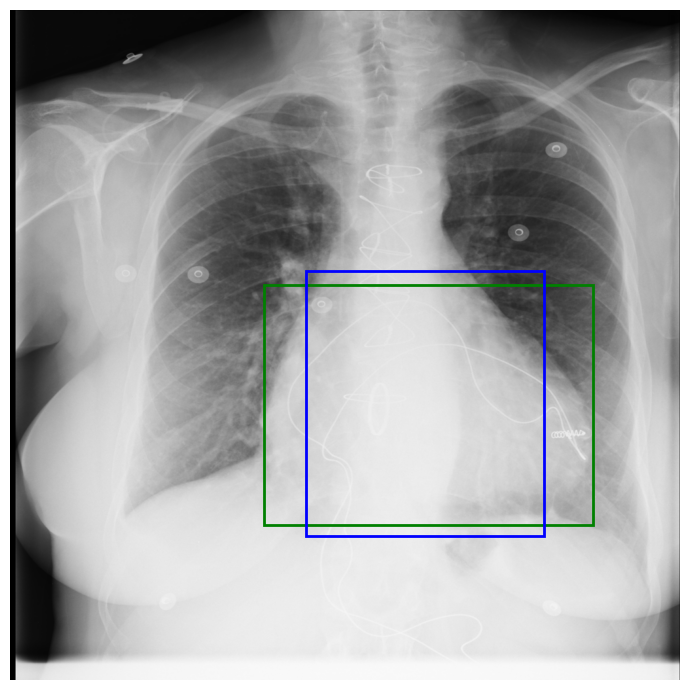

In [174]:
def visualize_boxes(df_test, df_pred, img_path):

    image = Image.open(img_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(9, 7))
    ax.imshow(image)
    ax.axis('off')

    def add_boxes(df, color, label_prefix):
        image_id = os.path.basename(img_path)
        subset = df[df['image_id'] == image_id]
        for _, row in subset.iterrows():
            x, y, w, h = row['x'], row['y'], row['w'], row['h']
            rect = patches.Rectangle(
                (x, y), w, h,
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)

    add_boxes(df_test, 'green', 'Ground Truth')
    add_boxes(df_pred, 'blue', 'Prediction')
    plt.tight_layout()
    plt.show()


visualize_boxes(
    df_test=df_test,
    df_pred=df_pred,
    img_path='/kaggle/working/true/00000377_004.png'
)